In [1]:
import pandas as pd
import numpy as np
import pickle
import sys
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Load Data

In [2]:
with open('../src/data/mta_data_march_cleaned.pickle', 'rb') as read_file:
    raw = pickle.load(read_file)
    
raw.head()


,C/A,UNIT,SCP,STATION,start_datetime,end_datetime,time_interval,entries
0,A002,R051,02-00-00,59 ST,2019-02-23 03:00:00,2019-02-23 07:00:00,04:00:00,11.0
1,A002,R051,02-00-00,59 ST,2019-02-23 07:00:00,2019-02-23 11:00:00,04:00:00,60.0
2,A002,R051,02-00-00,59 ST,2019-02-23 11:00:00,2019-02-23 15:00:00,04:00:00,160.0
3,A002,R051,02-00-00,59 ST,2019-02-23 15:00:00,2019-02-23 19:00:00,04:00:00,290.0
4,A002,R051,02-00-00,59 ST,2019-02-23 19:00:00,2019-02-23 23:00:00,04:00:00,143.0


# 2. Add Weekday

In [3]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1089652 entries, 0 to 1000172
Data columns (total 8 columns):
C/A               1089652 non-null object
UNIT              1089652 non-null object
SCP               1089652 non-null object
STATION           1089652 non-null object
start_datetime    1089652 non-null datetime64[ns]
end_datetime      1089652 non-null datetime64[ns]
time_interval     1089652 non-null timedelta64[ns]
entries           1089652 non-null float64
dtypes: datetime64[ns](2), float64(1), object(4), timedelta64[ns](1)
memory usage: 74.8+ MB


In [4]:
raw['weekday'] = raw.start_datetime.dt.weekday < 5


In [5]:
raw.weekday.value_counts()


True     779786
False    309866
Name: weekday, dtype: int64

# 3. Do Stations Follow One Time Schedule?

In [6]:
by_window = raw.groupby(['STATION', 'weekday', raw.start_datetime.dt.hour, raw.end_datetime.dt.hour])\
    .agg({ 'entries': ['sum', 'count'] })\
    .reset_index()

In [7]:
by_window.columns = ['_'.join(col).strip() for col in by_window.columns.values]
by_window = by_window.rename(columns={
    'STATION_': 'station',
    'start_datetime_': 'start_datetime',
    'end_datetime_': 'end_datetime',
    'weekday_': 'weekday'
})


In [8]:
by_window[by_window.station == '1 AV']


,station,weekday,start_datetime,end_datetime,entries_sum,entries_count
0,1 AV,False,0,3,342.00,40
1,1 AV,False,0,4,1763.00,50
2,1 AV,False,3,7,2.00,50
3,1 AV,False,4,8,405.00,50
4,1 AV,False,7,11,5.00,50
5,1 AV,False,8,12,2849.00,50
6,1 AV,False,11,15,10.00,50
7,1 AV,False,12,16,6204.00,50
8,1 AV,False,15,19,12.00,50
9,1 AV,False,16,20,6966.00,50


#### Conclusion

Can NOT assume that each station follows either the 0-4 time period or the 23-3 pattern. 

# 4. What's the Distribution Across Time Schedules?

In [9]:
by_window.end_datetime.value_counts().to_dict()

{23: 2270,
 8: 886,
 12: 877,
 16: 866,
 20: 817,
 4: 756,
 5: 638,
 11: 606,
 7: 573,
 9: 543,
 15: 543,
 19: 538,
 13: 509,
 17: 506,
 21: 473,
 3: 465,
 1: 406,
 10: 136,
 6: 131,
 14: 131,
 18: 106,
 22: 94,
 2: 54,
 0: 42}

In [10]:
# Ommit 23 hour because it's overrepresented by splitting records that overlapped a day
# Choose 5 times for each schedule to compare apples to apples
four_am_schedule = [4, 8, 12, 16, 20]
three_am_schedule = [3, 7, 11, 15, 19]
five_am_schedule = [5, 9, 13, 17, 21]
two_am_schedule = [2, 6, 10, 14, 18]

number_of_records_by_hour = raw.end_datetime.dt.hour.value_counts().to_dict()

for start_hour, schedule in [('4', four_am_schedule), ('3', three_am_schedule), ('5', five_am_schedule), ('2', two_am_schedule)]:
    total = sum([number_of_records_by_hour[hour] for hour in number_of_records_by_hour if hour in schedule])
    print(f'Record count for {start_hour}am schedule:', total)
    

Record count for 4am schedule: 400254
Record count for 3am schedule: 202881
Record count for 5am schedule: 203253
Record count for 2am schedule: 30122


#### Discussion

Roughly 1/2 the values fall along the 4am schedule. Roughly 1/4 fall along the 3am or 5am schedule. The 2am schedule is an order of magnitude less and in less important to consider

Options:
1. Split the entrants proportionally along every hour -> Will misrepresent commuter times (i.e. entrants are not equal 4am-8am)
2. Only use the 4am schedule -> miss half the data
3. Add the non-4am schedule records, to the nearest 4am schedule time interval

While imperfect, we felt the best solution was option 3. Given the vast majority of the data is only one hour on either side of the 4am based intervals, aggregating in this way should be sufficiently accurate. In addition, it creates a clean way to express and explain the data.

# 5. Code Time of Day For Each Record

In [11]:
def get_time_of_day(row):
    if (row.start_datetime.hour >= 2) and (row.end_datetime.hour <= 9):
        return 'early_morning'
    elif (row.start_datetime.hour >= 6) and (row.end_datetime.hour <= 13):
            return 'late_morning'
    elif (row.start_datetime.hour >= 10) and (row.end_datetime.hour <= 17):
            return 'afternoon'
    elif (row.start_datetime.hour >= 14) and (row.end_datetime.hour <= 21):
            return 'evening'
    else:
        return 'other'

In [12]:
raw['time_of_day'] = raw.apply(get_time_of_day, axis=1) # takes awhile. Might not scale

In [13]:
raw.head()

,C/A,UNIT,SCP,STATION,start_datetime,end_datetime,time_interval,entries,weekday,time_of_day
0,A002,R051,02-00-00,59 ST,2019-02-23 03:00:00,2019-02-23 07:00:00,04:00:00,11.0,False,early_morning
1,A002,R051,02-00-00,59 ST,2019-02-23 07:00:00,2019-02-23 11:00:00,04:00:00,60.0,False,late_morning
2,A002,R051,02-00-00,59 ST,2019-02-23 11:00:00,2019-02-23 15:00:00,04:00:00,160.0,False,afternoon
3,A002,R051,02-00-00,59 ST,2019-02-23 15:00:00,2019-02-23 19:00:00,04:00:00,290.0,False,evening
4,A002,R051,02-00-00,59 ST,2019-02-23 19:00:00,2019-02-23 23:00:00,04:00:00,143.0,False,other


# 6. Calculate Avg Entries for Each Time Period

In [14]:
by_day_and_time = raw.groupby(['STATION', 'weekday', raw.start_datetime.dt.date, 'time_of_day']).agg({ 'entries': 'sum'}).reset_index()

In [15]:
by_day_and_time.sample(20)

,STATION,weekday,start_datetime,time_of_day,entries
62204,UNION ST,True,2019-02-28,evening,2092.0
45205,JUNCTION BLVD,False,2019-03-03,afternoon,2977.0
63203,W 4 ST-WASH SQ,False,2019-03-03,early_morning,749.0
25695,BEACH 90 ST,True,2019-03-08,evening,99.0
63747,WALL ST,False,2019-03-17,afternoon,3041.0
41541,HARLEM 148 ST,False,2019-03-09,other,374.5
57475,RIT-ROOSEVELT,True,2019-02-26,other,121.0
44988,JKSN HT-ROOSVLT,True,2019-03-22,late_morning,16325.0
18021,79 ST,False,2019-03-16,early_morning,1051.0
49151,MONTROSE AV,True,2019-03-15,other,532.0


In [16]:
only_weekdays = by_day_and_time[by_day_and_time.weekday]

In [17]:
avg_by_time = only_weekdays.groupby(['STATION', 'time_of_day']).agg({ 'entries': 'mean' }).reset_index()

In [18]:
avg_by_time.head()

,STATION,time_of_day,entries
0,1 AV,afternoon,4003.88
1,1 AV,early_morning,1057.64
2,1 AV,evening,6292.32
3,1 AV,late_morning,4960.64
4,1 AV,other,3551.19


In [19]:
avg_by_time.describe()

,entries
count,1890.000000
mean,3137.850886
std,5182.619696
min,2.760000
25%,695.040000
50%,1565.806667
75%,3411.440000
max,67794.720000


The max is ~5 people per second (which seems reasonable)

# 7. Plot Recommended Stations

In [20]:
# top_20 = [
#     '34 ST-PENN STA',
#      'GRD CNTRL-42 ST',
# #      '34 ST-HERALD SQ',
# #      '23 ST',
#      '42 ST-PORT AUTH',
#      '14 ST-UNION SQ',
#      'TIMES SQ-42 ST',
#      'FULTON ST',
#      '86 ST',
#      '125 ST',
#      'CANAL ST',
#      '59 ST COLUMBUS',
#      '59 ST',
#      '14 ST',
#      '96 ST',
#      'CHAMBERS ST',
#      'FLUSHING-MAIN',
#      '47-50 STS ROCK',
#      'JKSN HT-ROOSVLT',
#      '50 ST'
# ]
recommended = ['CHAMBERS ST', 'GRD CNTRL-42 ST', 'FULTON ST', '47-50 STS ROCK', '23 ST', '34 ST-PENN STA']

In [21]:
to_chart = avg_by_time[(avg_by_time.STATION.isin(recommended))& (avg_by_time.time_of_day != 'other')]

In [22]:
to_chart.head()

,STATION,time_of_day,entries
230,23 ST,afternoon,25412.08
231,23 ST,early_morning,5279.76
232,23 ST,evening,50259.88
233,23 ST,late_morning,20076.48
305,34 ST-PENN STA,afternoon,25811.28


In [23]:
to_chart['total'] = to_chart.groupby(['STATION'])['entries'].transform('sum')

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [24]:
to_chart['percent'] = to_chart['entries'] / to_chart['total']

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
to_chart.head()

,STATION,time_of_day,entries,total,percent
230,23 ST,afternoon,25412.08,101028.20,0.251535
231,23 ST,early_morning,5279.76,101028.20,0.052260
232,23 ST,evening,50259.88,101028.20,0.497484
233,23 ST,late_morning,20076.48,101028.20,0.198722
305,34 ST-PENN STA,afternoon,25811.28,145735.12,0.177111


In [26]:
by_percent = to_chart.pivot(index='STATION', columns='time_of_day', values='percent').reset_index()

In [27]:
by_percent.head(6)

time_of_day,STATION,afternoon,early_morning,evening,late_morning
0,23 ST,0.251535,0.052260,0.497484,0.198722
1,34 ST-PENN STA,0.177111,0.142464,0.291376,0.389050
2,47-50 STS ROCK,0.201865,0.010701,0.725172,0.062263
3,CHAMBERS ST,0.266520,0.026847,0.552744,0.153889
4,FULTON ST,0.233380,0.081482,0.514990,0.170149
5,GRD CNTRL-42 ST,0.214103,0.090780,0.475179,0.219938


In [28]:
by_percent['total_morning'] = by_percent.early_morning + by_percent.late_morning
by_percent = by_percent.sort_values(['total_morning'])

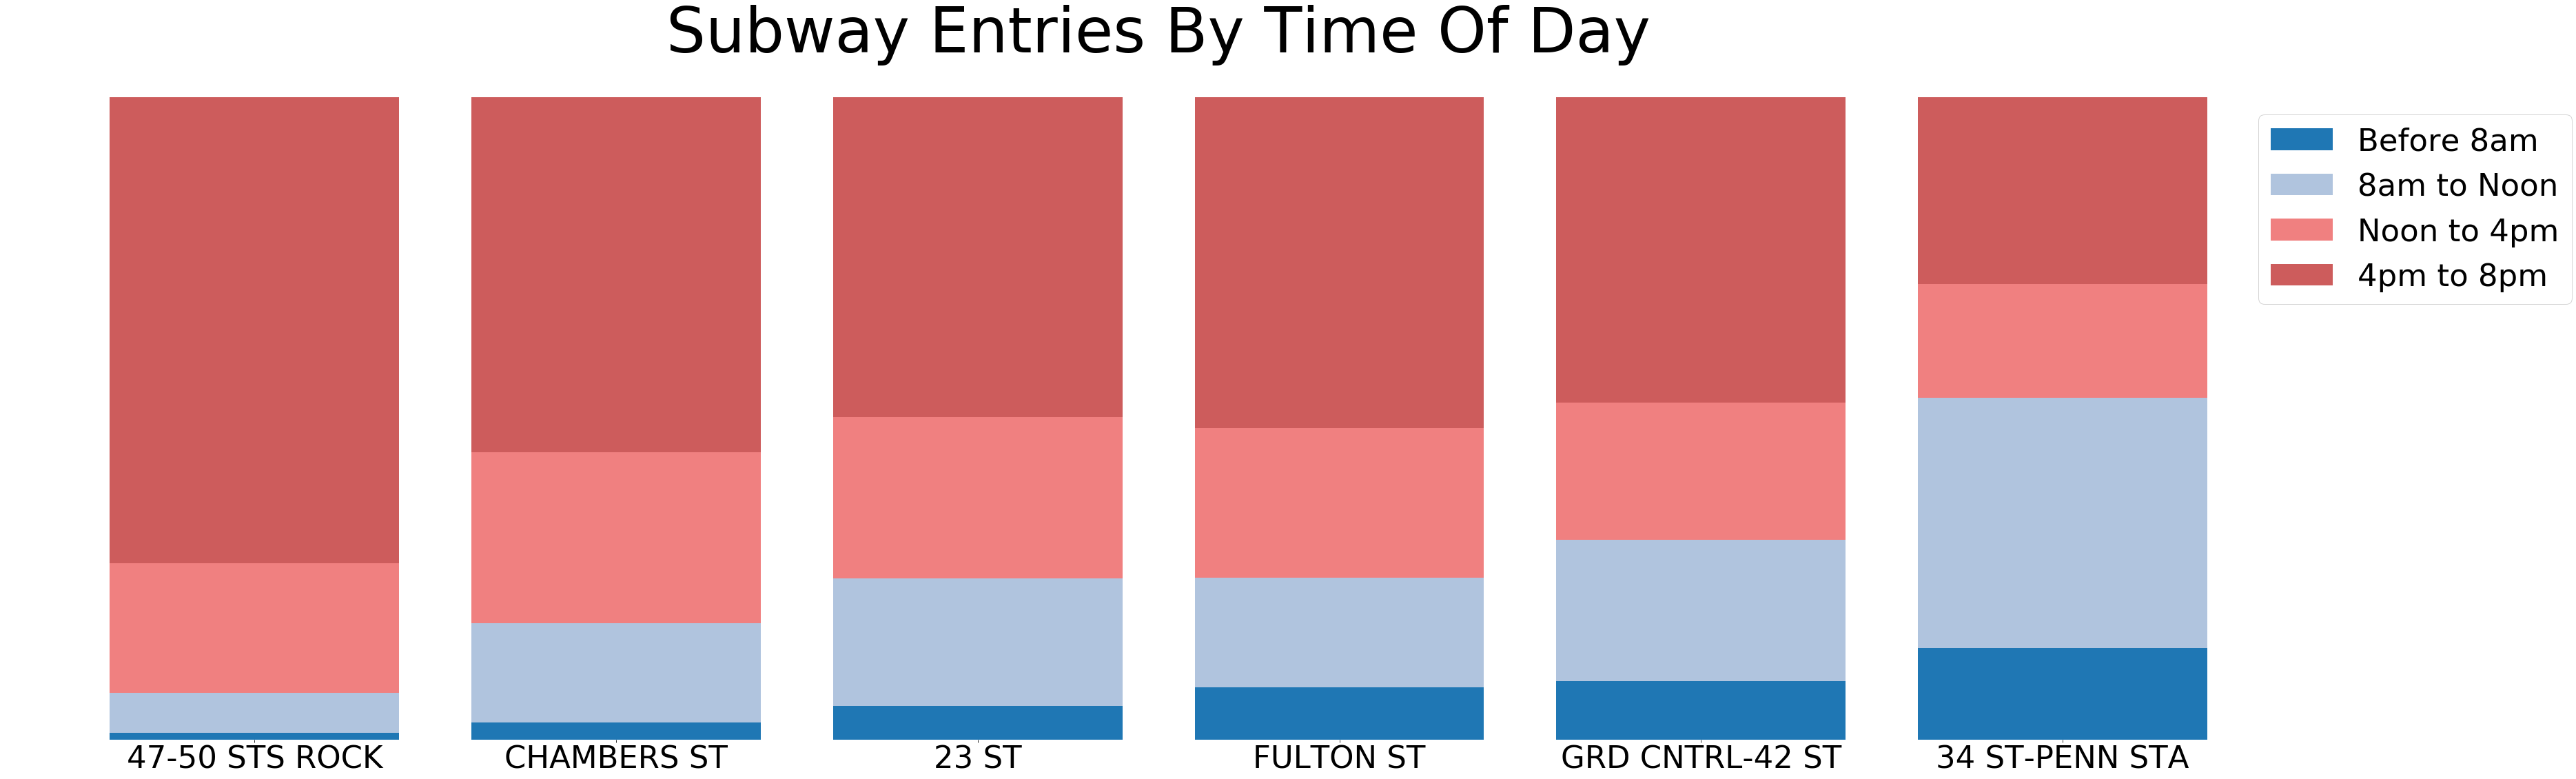

In [29]:
plt.figure(figsize=(60, 18))

plt.bar(by_percent.STATION, by_percent.early_morning, color='tab:blue')
plt.bar(by_percent.STATION, by_percent.late_morning, bottom=by_percent.early_morning, color='lightsteelblue')
plt.bar(by_percent.STATION, by_percent.afternoon, bottom=(by_percent.early_morning + by_percent.late_morning), color='lightcoral')
plt.bar(by_percent.STATION, by_percent.evening, bottom=(by_percent.early_morning + by_percent.late_morning + by_percent.afternoon), color='indianred')

plt.legend(['Before 8am', '8am to Noon', 'Noon to 4pm', '4pm to 8pm'], bbox_to_anchor=(0.97, .95), fontsize='45')
plt.title('Subway Entries By Time Of Day', fontsize='90')
plt.xticks(fontsize='45')
plt.yticks([])
plt.box(on=None)

plt.savefig('../src/visualization/top_station_by_time_of_day.jpg', format='jpg', quality=95)